# Notebook Objectives

In this notebooks, we'll go through the main behavioral analysis results.

Results include:
* ?
* ?

# Tutorial 2: Convolutional Neural Networks

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

**Production editors:** Spiros Chavlis

---
# Setup


In [1]:
# @title Imports
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score

from popy.io_tools import load_behavior, load_simulation
from popy.plotting.plotting_tools import *
from popy.behavior_data_tools import *
from popy.config import COLORS
from behav_analysis_tools import *

# Update the default font size
plt.rcParams.update({'font.size': 8})


In [9]:
##% plotting functions
def plot_probab_of_switch(probab_of_switch_full, x_bins, ax=None, monkey=None):
    """
    Plot the probability of switch as a function of the value function.
    """
    if ax is None:
        cm = 1/2.54  # centimeters in inches
        fig, ax = plt.subplots()
        fig.set_size_inches(4*cm, 3*cm)

    # first plot : probab of switch
    # plot mean
    linestyle = 'dashed' if monkey.split('_')[0] == 'simulation' else 'solid'
    alpha = .5 if monkey.split('_')[0] == 'simulation' else 1

    ax.plot(x_bins[:-1],
            np.mean(probab_of_switch_full, axis=0), 
            marker='o', 
            #linewidth=5, 
            #markersize=10,
            color='grey', #COLORS[monkey],
            markerfacecolor=COLORS[monkey.split('_')[-1]] if linestyle == 'solid' else 'white',
            markeredgecolor=COLORS[monkey.split('_')[-1]],
            #markeredgewidth=0.5,
            linestyle=linestyle,
            label=monkey.upper() if monkey is not None else 'Mean')
    # plot std
    '''ax.fill_between(x_bins[:-1], 
                    np.mean(probab_of_switch_full, axis=0) - np.std(probab_of_switch_full, axis=0), 
                    np.mean(probab_of_switch_full, axis=0) + np.std(probab_of_switch_full, axis=0), 
                    color=COLORS[monkey], alpha=0.2)'''

    # plot settings
    ax.set_ylabel('Probability of switch')
    ax.set_xlabel('Action value estimate')
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([-.05, 1.05])

    # hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    #ax.grid(alpha=0.3)
    ax.legend(frameon=True, loc='upper right')

    return ax

def plot_roc_curve(fpr, tpr, auc, ax=None, monkey=None):
    """
    Plot the ROC curve and the AUC.
    """
    if ax is None:
        cm = 1/2.54  # centimeters in inches
        fig, ax = plt.subplots()
        fig.set_size_inches(5*cm, 5*cm)
        # Set equal aspect ratio for the plot
        ax.set_aspect('equal', adjustable='box')

    # plot unbalance
    linestyle = 'dashed' if monkey.split('_')[0] == 'old' else 'solid'

    ax.plot(fpr, tpr, 
            label=f'{monkey.upper()}, AuC {auc:.2f}' if monkey is not None else 'ROC curve', 
            linewidth=1, color=COLORS[monkey.split('_')[-1]], linestyle=linestyle)
    # fill under the curve
    ax.fill_between(fpr, tpr, color='grey', alpha=.1)

    # plot chance
    ax.plot([0, 1], [0, 1], color='grey', linestyle='dashed')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(loc='lower right', frameon=True)

    # Adjust layout
    if ax.get_figure() is not None:
        ax.get_figure().tight_layout()

    return ax

In [3]:
# @title Data retrieval and loading

def get_data_custom():
    """
    Load the behavior data and preprocess it:
    - Add reaction time
    - Drop time fields
    - Add switch info (1/0 for switch/stay)
    """
    behav = load_behavior()
    behav = drop_time_fields(behav)

    simulation_ka = load_simulation(monkey='ka')
    simulation_po = load_simulation(monkey='po')
    behav = pd.concat([behav, simulation_ka, simulation_po], ignore_index=True)

    behav = add_value_function(behav)
    behav = add_switch_info(behav, add_trials_since_switch=False)        

    #behav = add_reaction_time(behav)

    return behav

def _convert_data_to_vectors(behav):
    """
    Convert the behavior data to vectors for the model.

    X: value function of each trial, shape (n_trials, 1)
    y: switch or stay (binaty, 1/0 resp.), shape (n_trials,)
    """
    # get data - X: value function, y: switch
    X = behav.value_function.values.reshape(-1, 1)
    #X = behav.fss_01.values.reshape(-1, 1)
    y = behav.switch.values
    y = y.astype(int)  # convert y to 0 and 1

    return X, y

def _get_probab_of_switch(X, y, x_bins):
    """
    Compute the probability of switch for each bin of the value function X.

    The probability of switch is computed as the ratio of y=1 and y=0 in the subset of x with window size of bin_size. Importantly, the classes are balanced by undersampling the majority class.
    """

    # run the model for random undersampling 1000 times, and store the probabs of switch
    probab_of_switch_full = []  # ratio of y=0 and y=1, in the subset of x with window size of bin_size

    for i in range(1000):
        # balance classes by undersampling majority class
        X_temp, y_temp = RandomUnderSampler().fit_resample(X, y)

        probab_of_switch_temp = []  # probab of switch in target for each bin
        for j in range(len(x_bins)-1):
            x_min = x_bins[j]
            x_max = x_bins[j+1]

            ids = np.argwhere((X_temp >= x_min) & (X_temp < x_max))[:, 0]
            probab_of_switch_temp.append(np.mean(y_temp[ids]))
        probab_of_switch_full.append(probab_of_switch_temp)
    probab_of_switch_full = np.array(probab_of_switch_full)

    return probab_of_switch_full

---
# Get data

In [4]:
behav = get_data_custom()
behav

,monkey,session,trial_id,block_id,best_target,target,feedback,value_function,switch
0,ka,010720,0,0,2,3.0,1.0,0.400000,NaN
1,ka,010720,1,0,2,3.0,0.0,0.666237,0.0
2,ka,010720,2,0,2,1.0,1.0,0.370609,1.0
3,ka,010720,3,0,2,1.0,0.0,0.649887,0.0
4,ka,010720,4,0,2,3.0,1.0,0.361514,1.0
...,...,...,...,...,...,...,...,...,...
78272,simulation_po,-1,15178,376,3,3.0,1.0,0.528690,0.0
78273,simulation_po,-1,15179,376,3,3.0,0.0,0.680797,0.0
78274,simulation_po,-1,15180,376,3,3.0,0.0,0.461082,0.0
78275,simulation_po,-1,15181,376,3,3.0,0.0,0.312276,0.0


---
# Section 2: Action value vs probab shift

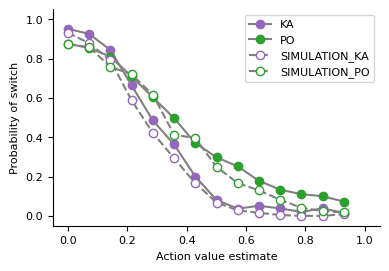

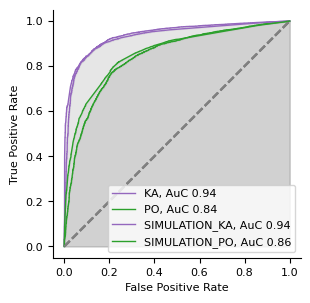

In [10]:
# Main plotting loop
fig_proba, ax_proba_shift = plt.subplots()
cm = 1/2.54
fig_proba.set_size_inches(10*cm, 7*cm)

fig_roc, ax_roc = plt.subplots()
fig_roc.set_size_inches(8*cm, 8*cm)
 # Set equal aspect ratio for the plot
ax_roc.set_aspect('equal', adjustable='box')

for monkey, behav_monkey in behav.groupby('monkey'):
    behav_monkey = behav_monkey.dropna()

    # get data for probability of switch plot
    X, y = _convert_data_to_vectors(behav_monkey)

    #X, y = RandomUnderSampler().fit_resample(X, y)

    nbins = 15
    x_bins = np.linspace(0, 1.001, nbins)
    probab_of_switch_full = _get_probab_of_switch(X, y, x_bins)
    
    # plot probability of switch
    ax_proba_shift = plot_probab_of_switch(probab_of_switch_full, x_bins, ax=ax_proba_shift, monkey=monkey)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y, X, drop_intermediate=False, pos_label=0)
    auc = roc_auc_score(-y, X)
    ax_roc = plot_roc_curve(fpr, tpr, auc, ax=ax_roc, monkey=monkey)

# Save the figures
fig_proba.tight_layout()
fig_roc.tight_layout()

fig_proba.savefig('figs/proba_shift.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')
fig_roc.savefig('figs/roc.svg', dpi=300, bbox_inches='tight', transparent=True, format='svg')

plt.show()
plt.close('all')
